#### Problema de negócio visualizado

O banco deseja melhorar seu processo de análise e aprovação de crédito pessoal, identificando padrões que influenciam na decisão de concessão de empréstimos. Atualmente, muitos pedidos são avaliados manualmente ou com base em critérios simples, o que pode resultar em aprovações indevidas ou recusas injustificadas. O objetivo deste projeto é utilizar técnicas de Machine Learning para prever, com base em características  dos clientes, a probabilidade de um empréstimo pessoal ser aprovado ou não.

#### Dicionário dos dados
O dataset é da Kaggle e possui 14 colunas e 5000 linhas.

- ID: Identificador do cliente.
- Age : Idade (em anos).
- Experience : Experiência de trabalho (em anos).
- Income : Renda anual (em milhares).
- ZipCode: Código postal da residência.
- Family : Número de membros da família.
- CCAvg: Média do gasto mensal com cartão de crédito (em milhares).
- Education: Nível de escolaridade do cliente.
    - 1: Graduação.
    - 2: Mestrado.
    - 3: Nível Avançado.
- Mortgage: Valor do financiamento, se existente (em milhares).
- Securities Account : Se o cliente tem ou não ativos ou títulos do banco.
- CD Account : Se o cliente tem ou não certificado de depósito bancário do banco.
- Online : Se o cliente tem ou não acesso a funcionalidades do Internet Banking.
- Credit Card : Se o cliente tem ou não cartão de crédito do banco.
- Personal Loan: Se o empréstimo pessoal foi ou não aprovado.
    - 0: empréstimo pessoal aprovado.
    - 1: empréstimo pessoal não aprovado.

#### Import das bibliotecas

In [29]:
# Manipulação e visualização de dados
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

# Pré-processamento de dados 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Classificadores 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Métricas de desempenho 
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# import shap

# Controle de warnings 
import warnings
warnings.filterwarnings('ignore')

##### Funções

In [30]:
def converter_colunas_para_string(df, colunas):
    """
    Converte as colunas especificadas para string no DataFrame.
    
    Parâmetros:
    - df: DataFrame do pandas
    - colunas: lista com os nomes das colunas a serem convertidas
    
    Retorna:
    - DataFrame com as colunas convertidas
    """
    for col in colunas:
        if col in df.columns:
            df[col] = df[col].astype(str)
        else:
            print(f"Coluna '{col}' não foi encontrada no DataFrame.")
    return df

#### Carregando os dados


In [31]:
df = pd.read_parquet("../data/dados_banco.parquet")

#### Analisando dados ausentes

In [32]:
df.nunique()

ID                    5000
Age                     45
Experience              47
Income                 162
ZIP.Code               467
Family                   4
CCAvg                  108
Education                3
Mortgage               347
Personal.Loan            2
Securities.Account       2
CD.Account               2
Online                   2
CreditCard               2
dtype: int64

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP.Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal.Loan       5000 non-null   int64  
 10  Securities.Account  5000 non-null   int64  
 11  CD.Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


##### Observações
- Não há dados repetidos, igualmente dados faltantes nas colunas observadas.
- Algumas colunas (como, por ex, Education, Mortgage, Credit Card) foram classificadas como dados numéricos, mas representam categorias, e precisarão ser tratadas no futuro para se encaixarem nas categorias específicas.

In [34]:
colunas_para_converter = ['ZIP.Code', 'Education', 'Personal.Loan', 'Securities.Account', 'CD.Account', 'Online', 'CreditCard']
df = converter_colunas_para_string(df, colunas_para_converter)

##### Exploração dos dados

In [35]:
df.head(5)

,ID,Age,Experience,Income,ZIP.Code,Family,CCAvg,Education,Mortgage,Personal.Loan,Securities.Account,CD.Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [36]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,5000.0,2500.500000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,45.338400,11.463166,23.0,35.00,45.0,55.00,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.00,20.0,30.00,43.0
Income,5000.0,73.774200,46.033729,8.0,39.00,64.0,98.00,224.0
Family,5000.0,2.396400,1.147663,1.0,1.00,2.0,3.00,4.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.70,1.5,2.50,10.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.00,0.0,101.00,635.0


##### Principais Insights Estatísticos

- **Age**: Idade média de 45 anos, variando de 23 a 67.

- **Experience**: Média de 20 anos, com valores negativos que indicam dados inválidos.

- **Income**: Renda média de US$ 73,7 mil, com grande variação e teto de US$ 224 mil.

- **Family**: Tamanho médio da família é 2,4 membros (entre 1 e 4).

- **CCAvg**: Gasto médio com cartão é US$ 1.938/mês, podendo chegar a US$ 10 mil.

- **Mortgage**: Metade dos clientes não possui financiamento; alguns têm até US$ 635 mil.

In [52]:
print(df['Personal.Loan'].value_counts(normalize=True) * 100)

0    90.4
1     9.6
Name: Personal.Loan, dtype: float64


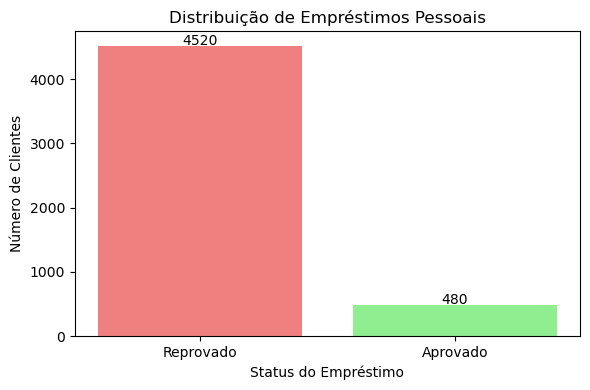

In [ ]:
loan_counts = df['Personal.Loan'].value_counts().sort_index()

# Rótulos (0 = Reprovado, 1 = Aprovado)
labels = ['Reprovado', 'Aprovado']

# Cores
colors = ['lightcoral', 'lightgreen']

# Plotando o gráfico
plt.figure(figsize=(6, 4))
plt.bar(labels, loan_counts, color=colors)

# Adicionando rótulos e título
plt.title('Distribuição de Empréstimos Pessoais')
plt.ylabel('Número de Clientes')
plt.xlabel('Status do Empréstimo')

# Adicionando os valores no topo das barras
for i, value in enumerate(loan_counts):
    plt.text(i, value + 20, str(value), ha='center')

plt.tight_layout()
plt.show()